In [43]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
%matplotlib inline

In [44]:
def run_query(q):
    with sqlite3.connect('C:/Users/Rob/Downloads/chinook.db') as conn:
        return pd.read_sql(q, conn)
    

In [45]:
def run_command(c):
    with sqlite3.connect('C:/Users/Rob/Downloads/chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [46]:
def show_tables():
    q ='''SELECT 
        name, 
        type
    FROM sqlite_master
    WHERE type IN ("table","view")'''
    return run_query(q)

In [47]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [48]:
q1 = '''
WITH usa AS
(
    SELECT il.* 
    FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = 'USA'
)

SELECT 
    g.name genre_name, 
    COUNT(usa.track_id) num_tracks_sold, 
    ROUND(CAST(COUNT(usa.track_id) as FLOAT) / 
    CAST((SELECT COUNT(track_id) 
          FROM usa) as FLOAT), 3) pct_tracks_sold
FROM usa
INNER JOIN track t on t.track_id = usa.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 3 DESC'''

genre_sales_usa = run_query(q1)
run_query(q1)

,genre_name,num_tracks_sold,pct_tracks_sold
0,Rock,561,0.534
1,Alternative & Punk,130,0.124
2,Metal,124,0.118
3,R&B/Soul,53,0.050
4,Blues,36,0.034
5,Alternative,35,0.033
6,Latin,22,0.021
7,Pop,22,0.021
8,Hip Hop/Rap,20,0.019
9,Jazz,14,0.013


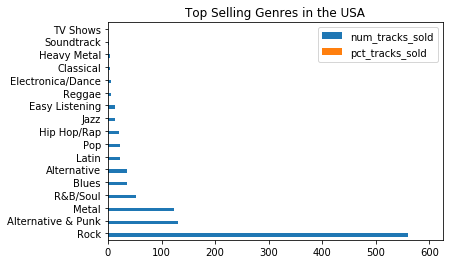

In [49]:
genre_sales_usa.set_index('genre_name', drop = True, inplace = True)
genre_sales_usa.plot.barh(
    title = 'Top Selling Genres in the USA',
    xlim = (0, 625),
)

plt.ylabel('')
plt.show()

The record store should purchase the pop, punk, and blues albums based on genre sales in the US.

In [50]:
q2 = '''
WITH boss_name AS
(SELECT 
    e1.last_name || ", " || e1.first_name e_name,
    e2.last_name || ", " || e2.first_name manager,
    e1.employee_id
FROM 
    employee e1
    LEFT JOIN employee e2 on e1.reports_to = e2.employee_id
)

SELECT 
    e.last_name || ", " || e.first_name employee_name,
    b.manager manager,
    e.hire_date hire_date,
    SUM(i.total) total_sales
FROM employee e
INNER JOIN boss_name b on b.employee_id = e.employee_id
LEFT JOIN customer c on e.employee_id = c.support_rep_id
INNER JOIN invoice i on i.customer_id = c.customer_id
GROUP BY 1
ORDER BY 4 DESC'''


run_query(q2)


    

,employee_name,manager,hire_date,total_sales
0,"Peacock, Jane","Edwards, Nancy",2017-04-01 00:00:00,1731.51
1,"Park, Margaret","Edwards, Nancy",2017-05-03 00:00:00,1584.00
2,"Johnson, Steve","Edwards, Nancy",2017-10-17 00:00:00,1393.92


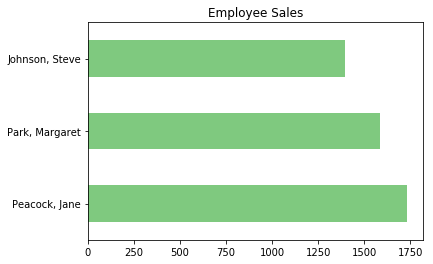

In [51]:
sales_perf = run_query(q2)
sales_perf.set_index('employee_name', drop = True, inplace = True)
sales_perf.plot.barh(legend = False, 
                     colormap = plt.cm.Accent,
                    title = 'Employee Sales')
plt.ylabel('')
plt.show()

The employees rank in sales according to their hire date. It is possible the longer an employee stays with the company, the more sales they will have.

In [52]:
q3 = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE country
       END AS country,
       c.customer_id,
       i.*
     FROM invoice i
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    avg_sales_per_cust,
    average_order    
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(total) total_sales,
        SUM(total) / count(distinct customer_id) avg_sales_per_cust,
        SUM(total) / count(invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(q3)

,country,customers,total_sales,avg_sales_per_cust,average_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


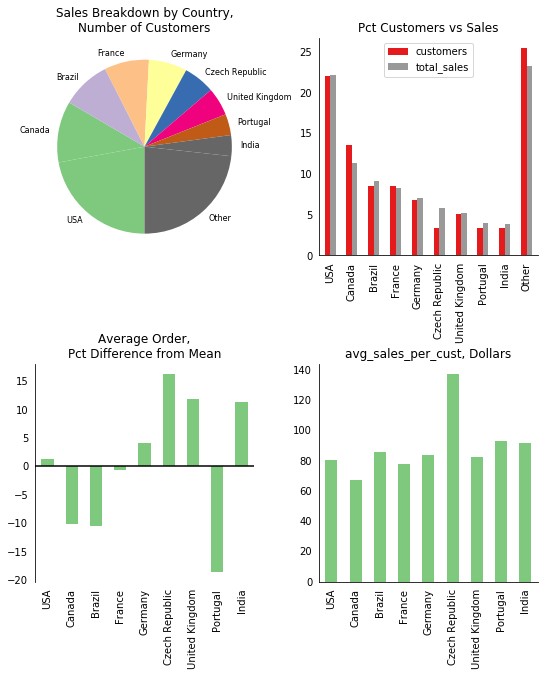

In [54]:
country_metrics = run_query(q3)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["avg_sales_per_cust"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="avg_sales_per_cust, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

In [55]:
df_il = run_query('select * from invoice_line')
df_il.to_csv('C:/Users/Rob/Downloads/df_il.csv')

In [56]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,497,0.809446
1,yes,117,0.190554


In [57]:
albums_vs_tracks_2 = '''
WITH invoice_first_track AS 
    (
     SELECT
         il.invoice_id invoice_id,
         i.customer_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1, 2
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ifs.*,
        t.album_id,
        CASE
            WHEN
                (
                 SELECT t3.track_id FROM track t3
                 WHERE t3.album_id = t.album_id
                 
                 EXCEPT
                 
                 SELECT il2.track_id FROM invoice_line il2
                 INNER JOIN invoice i2 ON i2.invoice_id = il2.invoice_id
                 INNER JOIN track t2 ON t2.track_id = il2.track_id
                 WHERE
                         il2.invoice_id <= ifs.invoice_id
                     AND i2.customer_id = ifs.customer_id
                     AND t2.album_id = t.album_id

                ) IS NULL THEN "yes"
            ELSE "no"
        END AS "album_purchase"
    FROM invoice_first_track ifs
    INNER JOIN track t ON ifs.first_track_id = t.track_id
    )
GROUP BY 1
'''

run_query(albums_vs_tracks_2)

,album_purchase,number_of_invoices,percent
0,no,475,0.773616
1,yes,139,0.226384
